# IMPORTING LIBRARIES 

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT = 3, 512, 512

# IMAGE AND MASK PREPOCESSING 

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Set correct dataset paths
img_path = r"C:\Users\rajpu\OneDrive\Desktop\Segmentation\segmentation_full_body_mads_dataset_1192_img\images"
mask_path = r"C:\Users\rajpu\OneDrive\Desktop\Segmentation\segmentation_full_body_mads_dataset_1192_img\masks"

# Get sorted list of image and mask filenames
X_ids = sorted(os.listdir(img_path))
y_ids = sorted(os.listdir(mask_path))

# Initialize numpy arrays
X_train = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_train = np.zeros((len(y_ids), 256, 256, 1), dtype=np.bool_)

# Load and preprocess images
for n, id_ in enumerate(X_ids):
    image = load_img(os.path.join(img_path, id_), target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = img_to_array(image)[90:450, 150:406]  # Cropping
    image = array_to_img(input_arr).resize((256, 256))
    X_train[n] = np.array(image)

# Load and preprocess masks
for n, id_ in enumerate(y_ids):
    image = load_img(os.path.join(mask_path, id_), target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    input_arr = img_to_array(image)[90:450, 150:406]  # Cropping
    image = array_to_img(input_arr).resize((256, 256))
    y_train[n] = np.array(image)[:, :, np.newaxis]

# Print dataset shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (1192, 256, 256, 3)
y_train shape: (1192, 256, 256, 1)


# DATA VISUALIZATION 

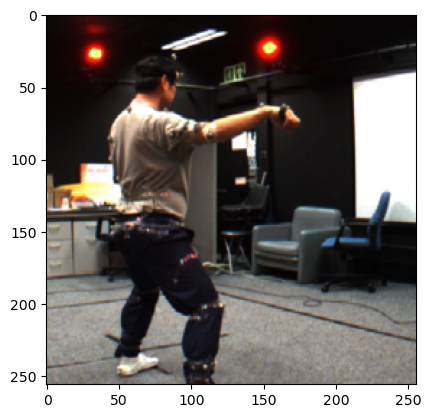

In [4]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_train[1000]))

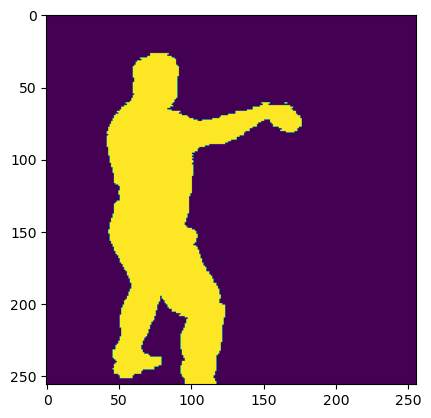

In [5]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(y_train[1000])) 

# DEFINING U-NET MODEL 

In [6]:
inputs = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)

c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)  

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7) 

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 256, 256, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ lambda[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

# MODEL TRAINING  

In [7]:
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=25)

Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8695 - loss: 0.4660 - val_accuracy: 0.8745 - val_loss: 0.2522
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9324 - loss: 0.1575 - val_accuracy: 0.9124 - val_loss: 0.1757
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9677 - loss: 0.0810 - val_accuracy: 0.9160 - val_loss: 0.1930
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9758 - loss: 0.0635 - val_accuracy: 0.9559 - val_loss: 0.1165
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9839 - loss: 0.0409 - val_accuracy: 0.9702 - val_loss: 0.0767
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9869 - loss: 0.0330 - val_accuracy: 0.9808 - val_loss: 0.0499
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9883 - loss: 0.0293 - val_accuracy: 0.9798 - val_loss: 0.0517
Epoch 8/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9889 - loss: 0.0278 - val_accuracy: 0.9817 - v

# RESULTS VISALIZATION     

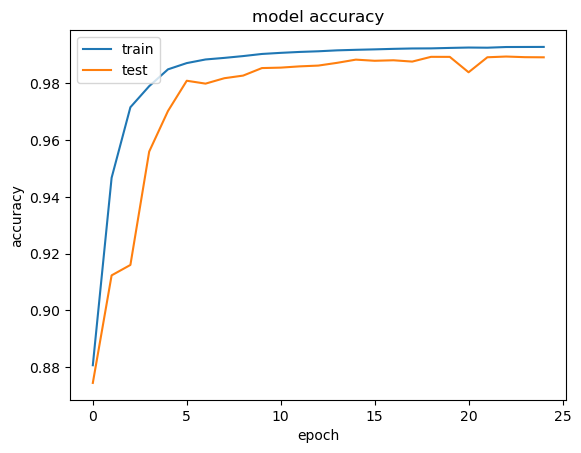

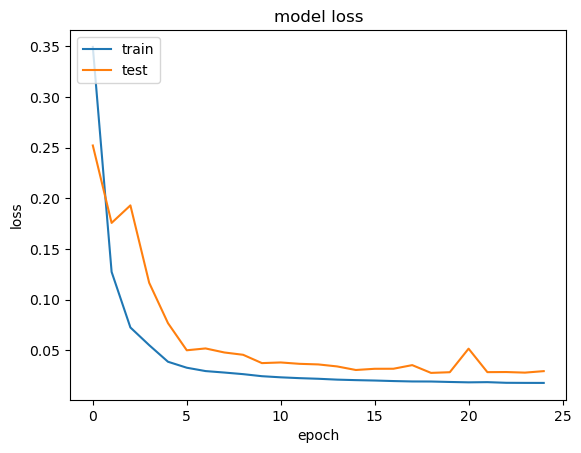

In [8]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
import random

test_id = random.choice(X_ids[-10:])
print(test_id)

Taichi_S6_C1_00585.png


In [10]:
img_path = rf"C:\Users\rajpu\OneDrive\Desktop\Segmentation\segmentation_full_body_mads_dataset_1192_img\images\{test_id}"

# Load and preprocess image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  

predictions = model.predict(input_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


# PREDICTED SEGMENTATION MASK  

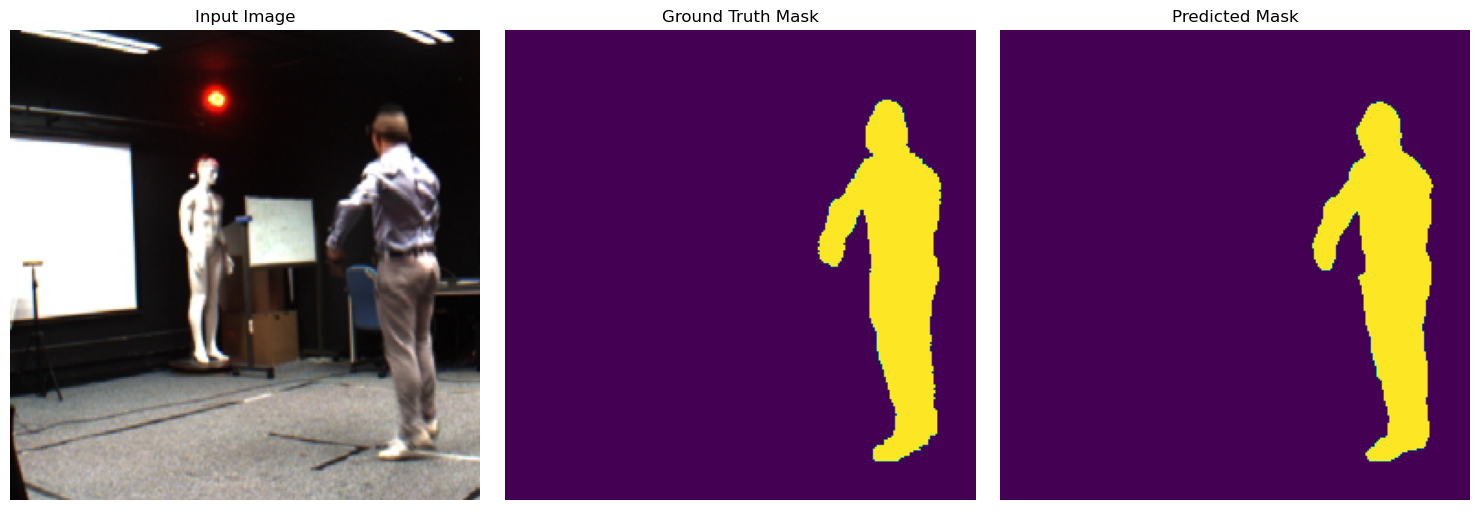

In [20]:
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(array_to_img(sample_image))
plt.title("Input Image")
plt.axis("off")

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(array_to_img(sample_mask))
plt.title("Ground Truth Mask")
plt.axis("off")

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(array_to_img(pred_mask_thresh))
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
